In [1]:
import numpy as np
import random
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, InputLayer, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from keras import optimizers
from keras.utils import np_utils
from skimage.draw import disk, rectangle,polygon #install scikit-image first
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (3,3)

Using TensorFlow backend.


In [2]:
np.random.seed(10)

### Generate Shapes

In [3]:
canvas_size=64
noisy=True
def create_disk(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    if noisy:
        canvas=np.random.rand(canvas_x, canvas_y)/2
    else:
        canvas=np.zeros((canvas_x, canvas_y), dtype=np.uint8)
    center=((bottom_right[0]+top_left[0])/2, (bottom_right[1]+top_left[1])/2)
    radius=(top_left[0]-bottom_right[0])/2
    canvas[tuple(disk(center, radius))] = 1
    return canvas

def create_rectangle(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    if noisy:
        canvas=np.random.rand(canvas_x, canvas_y)/2
    else:
        canvas=np.zeros((canvas_x, canvas_y), dtype=np.uint8)
    extent = (bottom_right[0]-top_left[0], bottom_right[1]-top_left[1])
    start  = top_left
    canvas[tuple(rectangle(start, extent=extent))] = 1
    return canvas

def create_triangle(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    if noisy:
        canvas=np.random.rand(canvas_x, canvas_y)/2
    else:
        canvas=np.zeros((canvas_x, canvas_y), dtype=np.uint8)
    x=[top_left[0],top_left[0],bottom_right[0]]
    y=[top_left[1],bottom_right[1],(top_left[1]+bottom_right[1])/2]
    canvas[tuple(polygon(x,y))] = 1
    return canvas

def create_random_shape(top_left, bottom_right,canvas_x=canvas_size,canvas_y=canvas_size):
    i = random.randint(1,3)
    if i==1:
        return create_disk(top_left, bottom_right,canvas_x,canvas_y)
    elif i==2:
        return create_rectangle(top_left, bottom_right,canvas_x,canvas_y)
    elif i==3:
        return create_triangle(top_left, bottom_right,canvas_x,canvas_y)

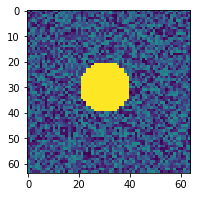

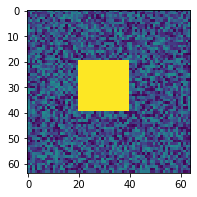

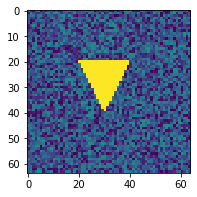

In [4]:
plt.imshow(create_disk((20,20),(40,40)))
plt.show()
plt.imshow(create_rectangle((20,20),(40,40)))
plt.show()
plt.imshow(create_triangle((20,20),(40,40)))
plt.show()

### Generate Training data

In [5]:
X_train,X_test,Y_train,Y_test=[],[],[],[]
for i in range(5000): #generate train set
    top_left=(random.randint(int(0.25*canvas_size),int(0.75*canvas_size)),random.randint(int(0.25*canvas_size),int(0.75*canvas_size)))
    side_length=random.randint(int(0.1*canvas_size),int(0.2*canvas_size))
    bottom_right=(top_left[0]+side_length,top_left[1]+side_length)
    X_train+=[create_random_shape(top_left, bottom_right)]
    Y_train+=[top_left+bottom_right]
for i in range(200): #generate test set
    top_left=(random.randint(int(0.25*canvas_size),int(0.75*canvas_size)),random.randint(int(0.25*canvas_size),int(0.75*canvas_size)))
    side_length=random.randint(int(0.1*canvas_size),int(0.2*canvas_size))
    bottom_right=(top_left[0]+side_length,top_left[1]+side_length)
    X_test+=[create_random_shape(top_left, bottom_right)]
    Y_test+=[top_left+bottom_right]
X_train=np.array(X_train)
Y_train=np.array(Y_train)

X_test=np.array(X_test)
Y_test=np.array(Y_test)

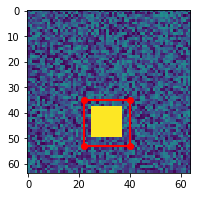

In [6]:
def plot(X,Y):
    plt.imshow(X)
    padding=int(0.05*canvas_size)
    plt.scatter([Y[1]-padding,Y[3]+padding,Y[1]-padding,Y[3]+padding],\
                [Y[0]-padding,Y[2]+padding,Y[2]+padding,Y[0]-padding],c='red')
    ax = plt.gca()
    ax.add_patch(patches.Rectangle((Y[1]-padding,Y[0]-padding),Y[3]-Y[1]+2*padding,\
                                   Y[2]-Y[0]+2*padding,linewidth=2,edgecolor='r',facecolor='none'))
    return plt
plot(X_train[0],Y_train[0]).show()

### Convert data

In [7]:
X_train = X_train.reshape(X_train.shape[0], canvas_size, canvas_size,1)
X_test = X_test.reshape(X_test.shape[0], canvas_size, canvas_size,1)

#Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')/canvas_size
Y_test = Y_test.astype('float32')/canvas_size

### Build Model

In [8]:
convolutional=False
if convolutional:
    model = Sequential()
    model.add(MaxPooling2D(pool_size=(2,2),input_shape=(canvas_size,canvas_size,1)))
    model.add(Convolution2D(8, (3,3)))
    model.add(Convolution2D(8, (3,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(8, (3,3)))
    model.add(Convolution2D(8, (3,3)))
    model.add(Flatten())
    model.add(Dense(4))
    model.build()
else:
    model = Sequential()
    model.add(InputLayer(input_shape=(canvas_size,canvas_size,1)))
    model.add(Flatten())
    model.add(Dense(96))
    model.add(Dense(64))
    model.add(Dense(4))
    model.build()

### Train

In [9]:
model.compile(optimizer='adam',loss='mse')

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                393312    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 399,780
Trainable params: 399,780
Non-trainable params: 0
_________________________________________________________________


In [11]:
history=model.fit(X_train, Y_train, epochs=20,validation_split=0.1, shuffle=True, verbose=1)

Train on 4500 samples, validate on 500 samples
Epoch 1/20
4500/4500 [==============================] - 3s 560us/step - loss: 1.0152 - val_loss: 0.0686
Epoch 2/20
4500/4500 [==============================] - 2s 414us/step - loss: 0.0475 - val_loss: 0.0398
Epoch 3/20
4500/4500 [==============================] - 2s 354us/step - loss: 0.0294 - val_loss: 0.0285
Epoch 4/20
4500/4500 [==============================] - 2s 387us/step - loss: 0.0188 - val_loss: 0.0247
Epoch 5/20
4500/4500 [==============================] - 2s 400us/step - loss: 0.0135 - val_loss: 0.0244
Epoch 6/20
4500/4500 [==============================] - 2s 389us/step - loss: 0.0112 - val_loss: 0.0198
Epoch 7/20
4500/4500 [==============================] - 2s 460us/step - loss: 0.0102 - val_loss: 0.0207
Epoch 8/20
4500/4500 [==============================] - 2s 372us/step - loss: 0.0076 - val_loss: 0.0162
Epoch 9/20
4500/4500 [==============================] - 2s 433us/step - loss: 0.0077 - val_loss: 0.0124
Epoch 10/20
4500/

NameError: name 'size' is not defined

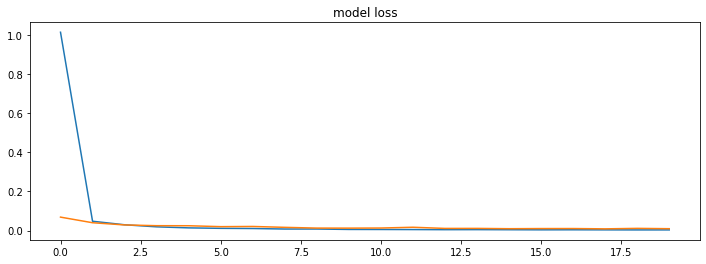

In [12]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss',size)
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('train_trad.png',transparent=True)

### Evaluate

In [13]:
score = model.evaluate(X_test, Y_test, verbose=1)
print("loss: ", score)

200/200 [==============================] - 0s 66us/step
loss:  0.009449672251939774


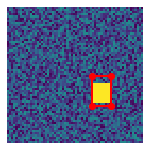

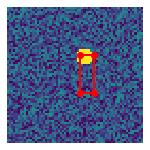

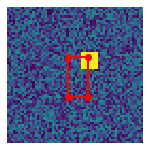

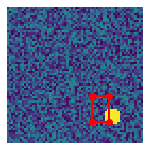

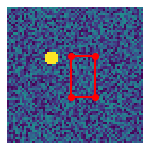

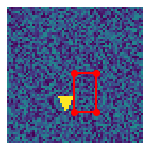

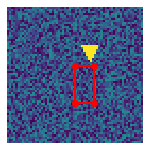

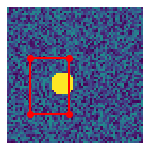

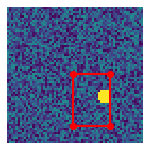

In [33]:
for i in range(9):
    plt.figure(figsize=(2.5,2.5),linewidth=3,edgecolor="#ffffff")
    k = random.randint(0,len(X_test))-1
    x=X_test[k].flatten().reshape(canvas_size,canvas_size)
    y=model.predict(np.array([X_test[k]]))[0]*canvas_size
    im=plot(x,y)
    plt.axis('off')
    plt.savefig('test_dense'+str(i)+'.png',bbox_inches='tight',pad_inches=0)#,transparent=True)

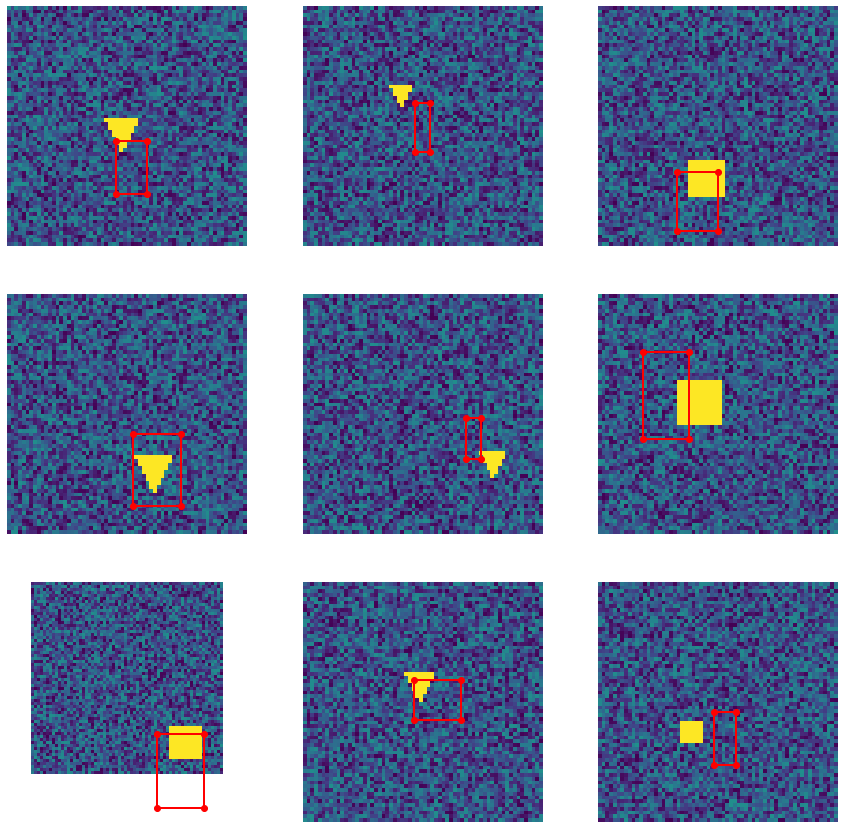

In [21]:
plt.figure(figsize=(15,15))
for i in range(9):
    
    ax= plt.subplot(3,3,i+1)
    ax.linewidth=10
    ax.edgecolor="#04253a"
    k = random.randint(0,len(X_test))-1
    x=X_test[k].flatten().reshape(canvas_size,canvas_size)
    y=model.predict(np.array([X_test[k]]))[0]*canvas_size
    im=plot(x,y)
    plt.axis('off')
plt.savefig('test_dense.png',transparent=True)

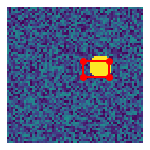

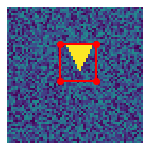

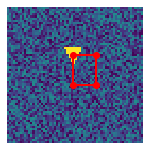

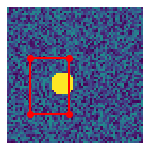

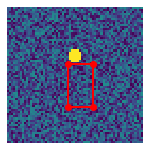

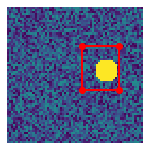

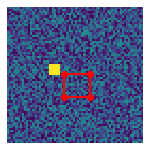

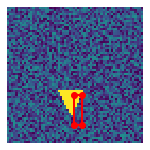

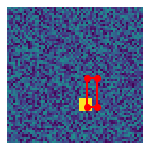

In [29]:
for i in range(9):
    plt.figure(figsize=(2.5,2.5),linewidth=3,edgecolor="#ffffff")
    k = random.randint(0,len(X_test))-1
    x=X_test[k].flatten().reshape(canvas_size,canvas_size)
    y=model.predict(np.array([X_test[k]]))[0]*canvas_size
    im=plot(x,y)
    plt.axis('off')
    plt.savefig('test_conv'+str(i)+'.png',bbox_inches='tight',pad_inches=0)#,transparent=True)